In [1]:
import ray.tune as tune
from ray.rllib.agents.ppo import PPOTrainer
from ray.tune import register_env
from envs.env_creator import env_creator, ibgym_env_creator_rllib
from envs.IBGym_mod_envs import IBGymModded
from ppo.policy import LSTMPPOPolicy
from base_rl.eval_policy import EvalDiscreteStatePolicy
from ppo.policy import LSTMPPOPolicy
from envs.plot import plot_industrial_benchmark_trajectories

## Configure Training

In [2]:


register_env("IBGym-v1", ibgym_env_creator_rllib)
save_path = 'tmp/ppo/lstm_ppo_policy.pkl'
config = {
    # Environment (RLlib understands openAI gym registered strings).
    "env": "IBGym-v1",
    # Use 2 environment workers (aka "rollout workers") that parallelly
    # collect samples from their own environment clone(s).
    "num_workers": 12,
    "num_gpus": 1,

    # Change this to "framework: torch", if you are using PyTorch.
    # Also, use "framework: tf2" for tf2.x eager execution.
    "framework": "tf",
    "entropy_coeff": 0.0001,
    # "entropy_coeff_schedule":PiecewiseSchedule(endpoints=[(0, 0.01), (143000, 0.00001)]),
    "lr": 3e-4,
    "gamma": 0.994,
    "clip_param": 0.2,
    #"seed": 5321,
    "num_sgd_iter": 2,
    "sgd_minibatch_size": 1000,

    # "vf_loss_coeff": 1e-9,
    # "vf_clip_param": 1e7,
    # Tweak the default model provided automatically by RLlib,
    # given the environment's observation- and action spaces.
    "model": {
        # == LSTM ==
        # Whether to wrap the model with an LSTM.
        "use_lstm": True,
        # Max seq len for training the LSTM, defaults to 20.
        "max_seq_len": 30,
        # Size of the LSTM cell.
        "lstm_cell_size": 64,
        # "use_attention": True,
        # "attention_num_transformer_units": 2,
        # "attention_dim": 128,
        # "vf_share_layers": True,
        # "fcnet_hiddens": [32, 32, 32],
        # "sgd_minibatch_size": 1024,
        "vf_share_layers": False,
        # Whether to feed a_{t-1} to LSTM (one-hot encoded if discrete).
        "lstm_use_prev_action": False,
        # Whether to feed r_{t-1} to LSTM.
        "lstm_use_prev_reward": False,
        # Whether the LSTM is time-major (TxBx..) or batch-major (BxTx..).
        "_time_major": False,
    },
    "train_batch_size": 32000,
    "timesteps_per_iteration": 32000,
    # "output": "tmp/ib-out",
    # Set up a separate evaluation worker set for the
    # `trainer.evaluate()` call after training (see below).
    "evaluation_num_workers": 3,
    # Only for evaluation runs, render the env.
    "evaluation_config": {
        "render_env": False,
    },
}

In [ ]:
results = tune.run(
        PPOTrainer,
        config=config,
        name="industrial_benchmark",
        local_dir="tmp/ray_exp_logs",
        checkpoint_freq=5,
        # stop={"training_iteration": 5},
        sync_config=tune.SyncConfig(
            syncer=None  # Disable syncing
        )
    )

In [3]:
policy = LSTMPPOPolicy(config=config, checkpoint_path='tmp/ray_exp_logs/industrial_benchmark/PPOTrainer_IBGym-v1_764de_00000_0_2022-10-24_12-56-07/checkpoint_000165/checkpoint-165')
policy.save(save_path)

In [4]:
policy = LSTMPPOPolicy.load(save_path)
env_kwargs = {'steps_per_episode': 1000,'config': None}
algo = EvalDiscreteStatePolicy(policy=policy, env_creator=ibgym_env_creator_rllib, env_kwargs=env_kwargs)

Episode 9 Reward: -184.85090378257019 || New State Found: False


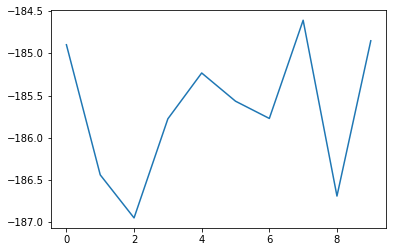

Reward Mean: -185.6770815704639
Reward std : 0.7664288781659304


In [5]:
algo.evaluate(epochs=10)

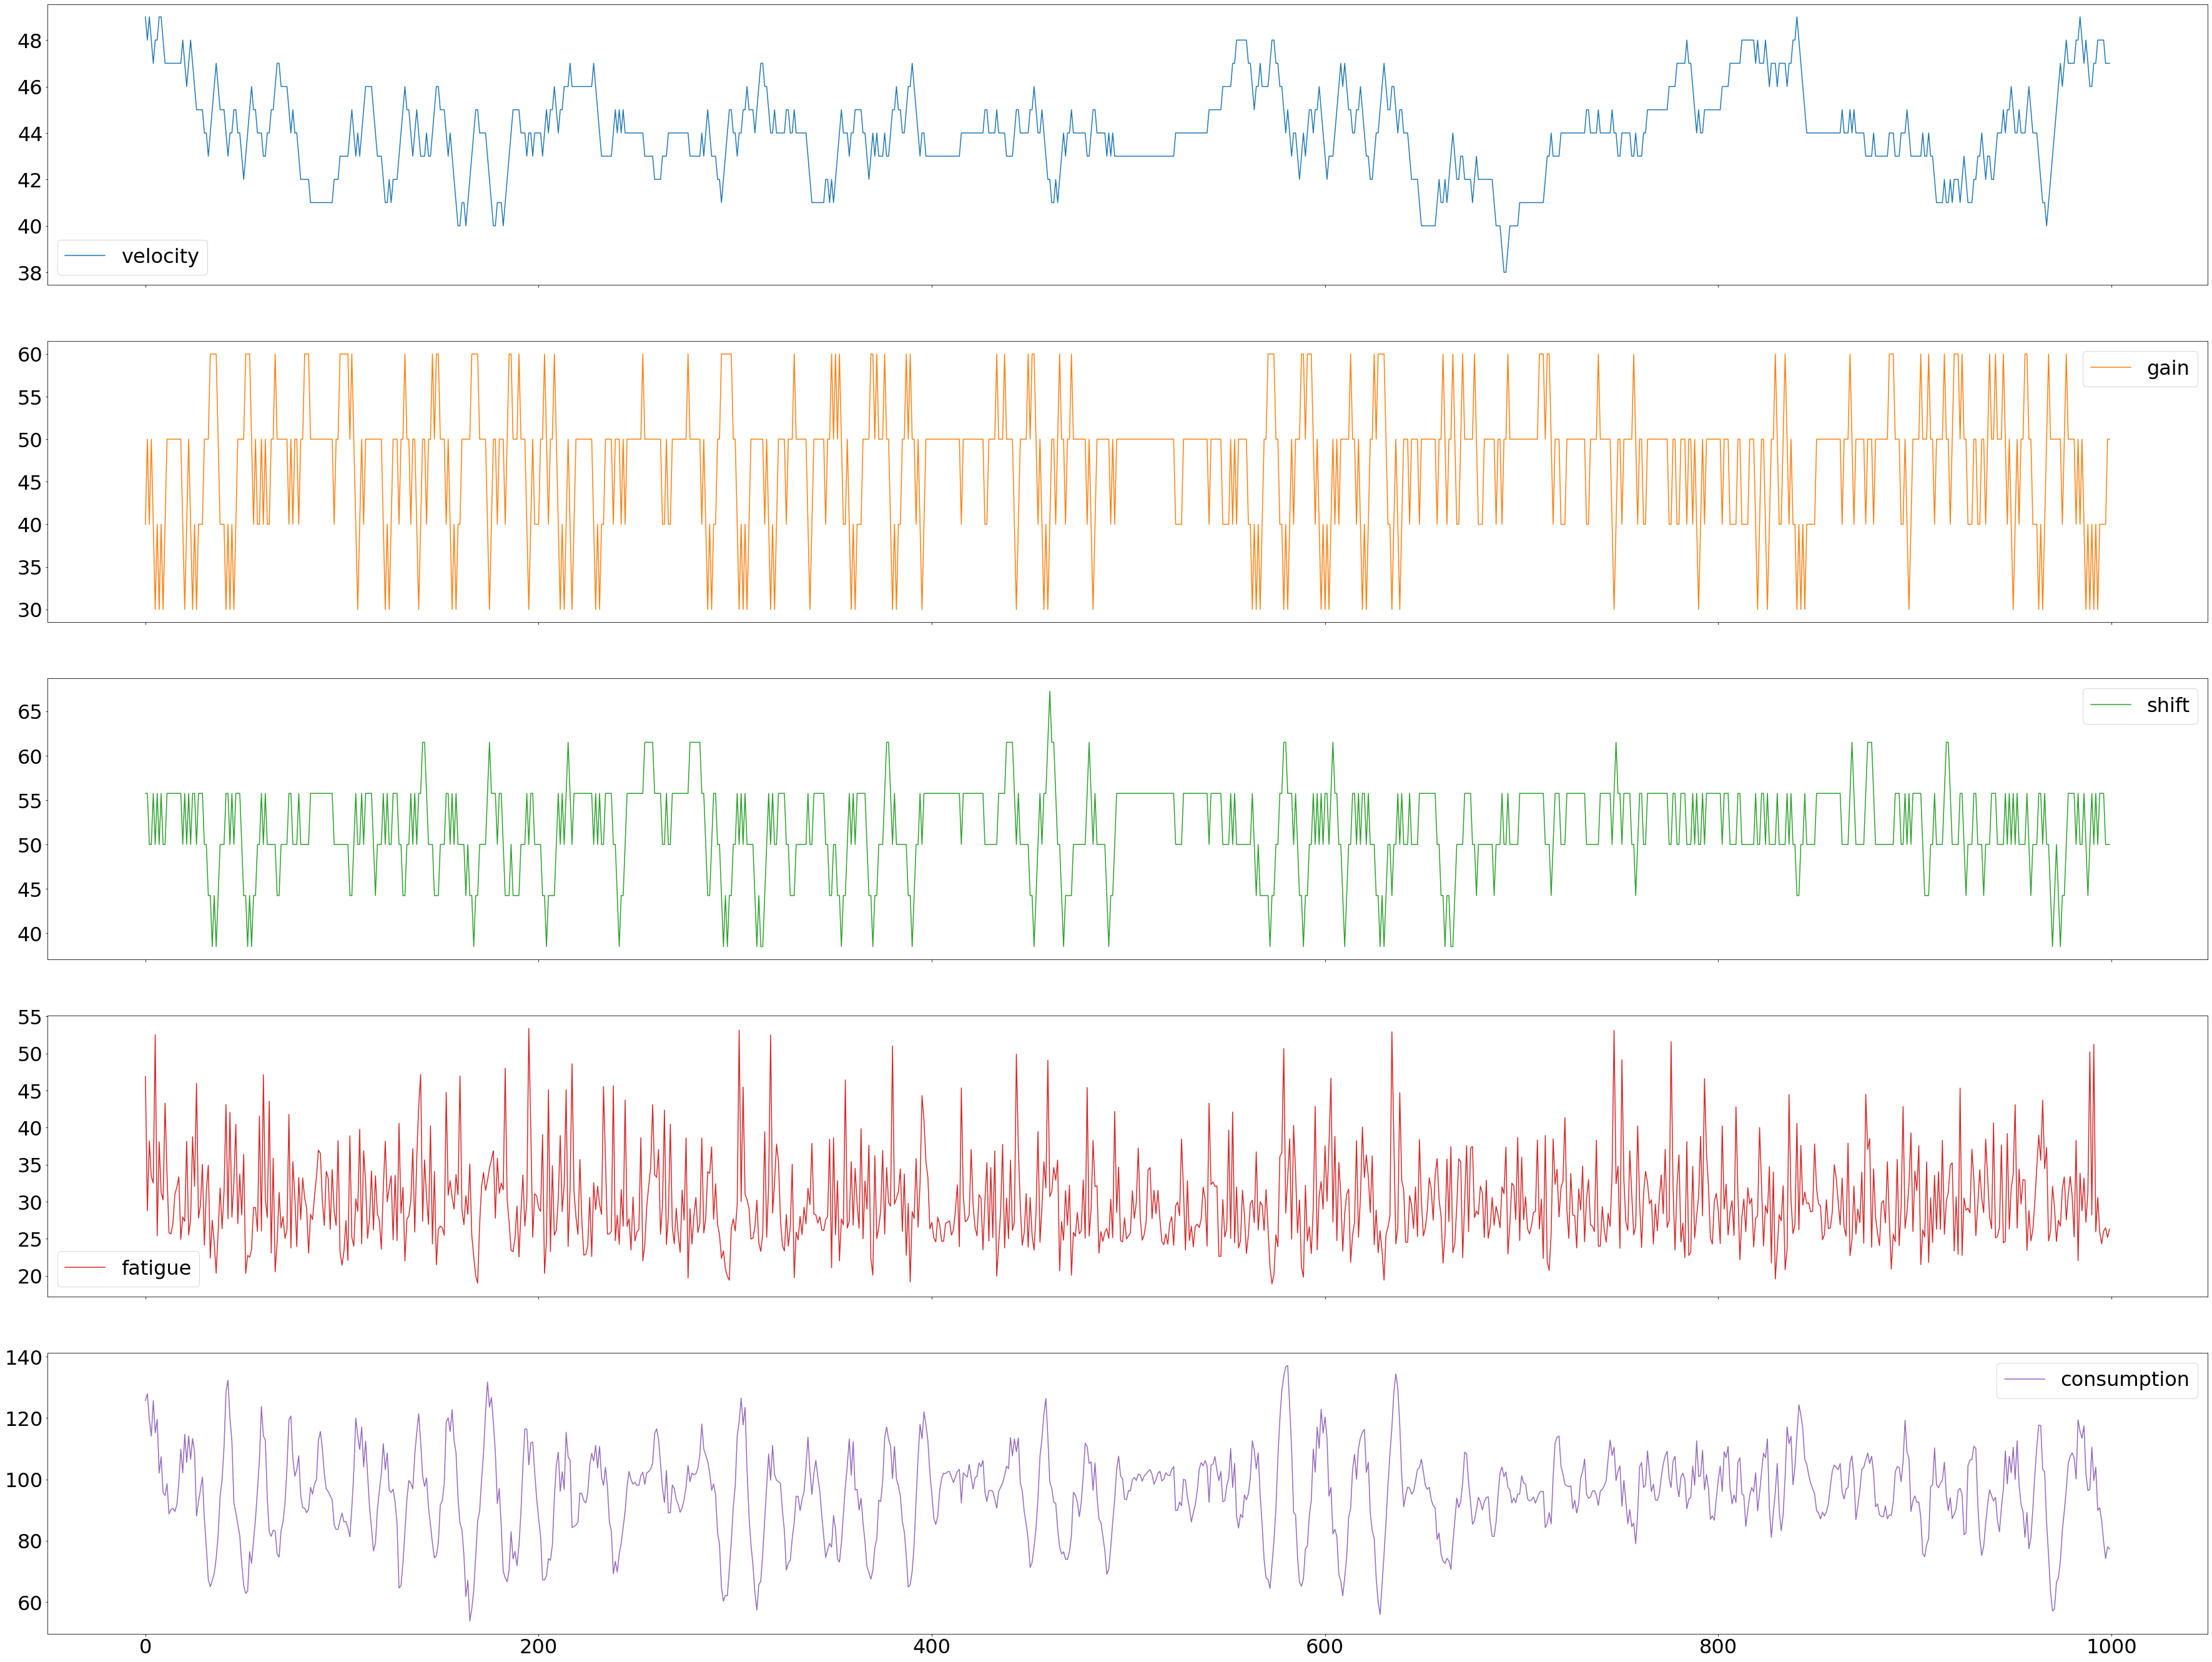

In [6]:
plot_industrial_benchmark_trajectories(algo.eval_trajectories[5]['info'])